<h1>
<center>
Assignment 5: PCA, Naive Bayes, Clustering, and Deep Learning
</center>
</h1>
<center>
CS 4262/5262 - Foundations of Machine Learning<br>
Vanderbilt University, Spring 2024<br>
Due: Check Brightspace
</center>
<hr>
<br>This assignment will focus on: (1) PCA, (2) Clustering, and (3) deep learning. In addition to programming tasks, there are short-answer questions throughout the notebook. 

Contact: Gary Chung kuan-i.chung@vanderbilt.edu for any clarifying questions.


### Please enter your name:  <font color='blue'> Yuanhe Li

--- 
## Part 1: Eigencats


In this part, you will be working with a dataset of cat images. You will apply principal component analysis (PCA) to decompose the data into "eigencats", and use the eigencat basis to form low-dimensional approximations of the original data.

- Load the cat dataset from the file "cats.csv" (should be included in the git repo; here is the original source: https://github.com/bioramble/pca). This dataset consists of a 4096 x 80 matrix of "pre-flattened" 64 x 64 images of cats (i.e., each of eighty 64 x 64 image has been flattened into a vector of length 4096).
- A function for loading the dataset has been provided below, so you just need to call it.


In [1]:
# code for loading dataset into matrix
# returns a matrix where each of the 80 rows represents a cat image 
# and the 4096 columns represent features (pixels) of the images

import csv
import numpy as np

def load_cat_file(file_path):
    cat_matrix = np.zeros((80,4096))
    with open(file_path) as f:
        cat_reader = csv.reader(f, delimiter=',')
        for i, line in enumerate(cat_reader):
            pixels = [int(p) for p in line]
            cat_matrix[:,i] = pixels
    return cat_matrix
            
cat_matrix = load_cat_file('cats.csv')
print(cat_matrix.shape)


(80, 4096)


- The next block of code provides a function for visualizing a single cat image, given a flattened image as input.
   


In [2]:
# function for visualizing a cat image
import matplotlib.pyplot as plt

def vis_cat_image(cat_vec, axis=None):
    cat_img = np.reshape(cat_vec, (64,64)).T 
    if axis is None:
        plt.imshow(cat_img, interpolation='nearest', cmap=plt.cm.gray)
        plt.axis('off')
        plt.show()
    else: 
        axis.imshow(cat_img, interpolation='nearest', cmap=plt.cm.gray)

 * To familiarize yourself with the data, use the function above to display a single cat image of your choosing.
   

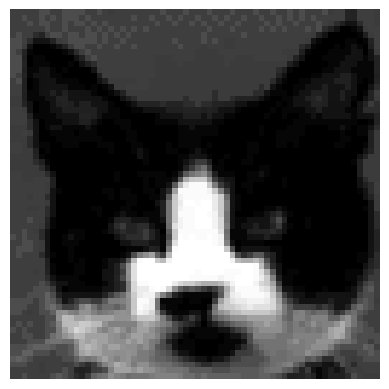

None


In [3]:
# The first image is actually a meme in Chinese internet :)
print(vis_cat_image(cat_matrix[0]))

* Next, display the average over all 80 cat images:

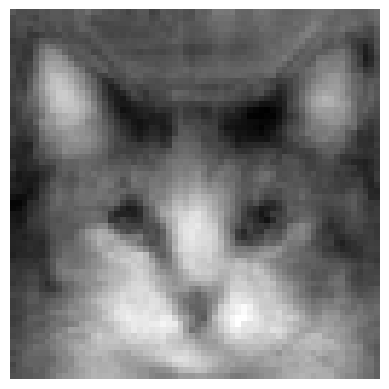

None


In [4]:
average_cat = np.mean(cat_matrix, axis=0)
print(vis_cat_image(average_cat))

You will next perform PCA on the cat dataset to extract a set of "eigencats".
- Recall that it is important to perform feature scaling prior to PCA. First, please mean-center and standardize over features in the cat dataset.
- Next, calculate the eigenvectors and eigenvalues of the covariance matrix. **Do not use PCA from scikit-learn**, but you can use numpy functions. Please be sure to read and understand the documentation of those functions. 
- Display (as images) the top 16 "eigencats" (i.e., the 16 eigenvectors corresponding to the largest 16 eigenvalues). You can use the function `vis_cat_image` above. Place a title on each image that indicates which of the eigencats is displayed, where 'eigencat 1' corresponds to the largest eigenvalue and 'eigencat 16' corresponds to the 16th-largest eigenvalue.
- Display a plot of the eigenvalues, ordered from largest to smallest. Include a title and label the axes.

In [5]:
import numpy as np
from scipy import linalg as LA

In [6]:
# You don't have to use this class.
# You can implement your own PCA class/function.

class PCA:
    def __init__(self, data):
        # Preprocess: zero out the mean and rescale to unit variance
        self.data = data - np.mean(data, axis=0)
        self.data = self.data / np.std(self.data, axis=0)

        # Compute the covariance matrix
        self.cov_matrix = np.cov(self.data, rowvar=False)

        # Compute the eigenvalues and eigenvectors
        self.eigenvalues, self.eigenvectors = LA.eigh(self.cov_matrix)

        # Sort the eigenvalues and eigenvectors in descending order
        idx = np.argsort(self.eigenvalues)[::-1]
        self.eigenvalues = self.eigenvalues[idx]
        self.eigenvectors = self.eigenvectors[:,idx]

    @property
    def percent_variance_explained(self):
        total_variance = np.sum(self.eigenvalues)
        explained = [(i / total_variance) for i in self.eigenvalues]
        return np.cumsum(explained)
    
    def get_number_of_components_by_variance_explained(self, p=.9):
        return np.where(self.percent_variance_explained >= p)[0][0] + 1
    
    def project(self, num_components):
        projection_matrix = self.eigenvectors[:, :num_components]
        return np.dot(self.data, projection_matrix)
    
    def reconstruct(self, num_components):
        projection_matrix = self.eigenvectors[:, :num_components]
        return np.dot(self.project(num_components), projection_matrix.T)

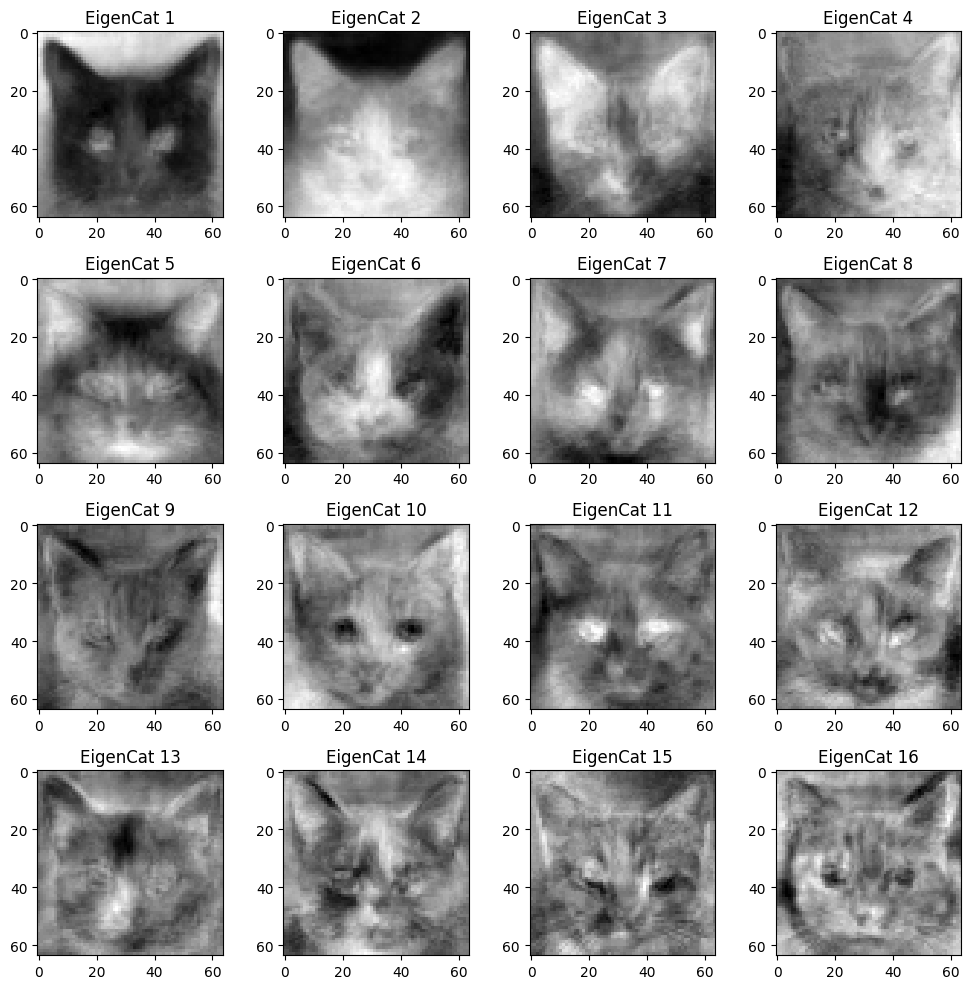

In [7]:
# plot "eigencats", the visialized eigen vectors

# Assuming pca is an instance of the PCA class initialized with cat_matrix
pca = PCA(cat_matrix)

# Visualize the top 16 eigencats
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    ax = axes[i//4, i%4]
    vis_cat_image(pca.eigenvectors.T[i], axis=ax)
    ax.set_title(f'EigenCat {i+1}')
plt.tight_layout()
plt.show()

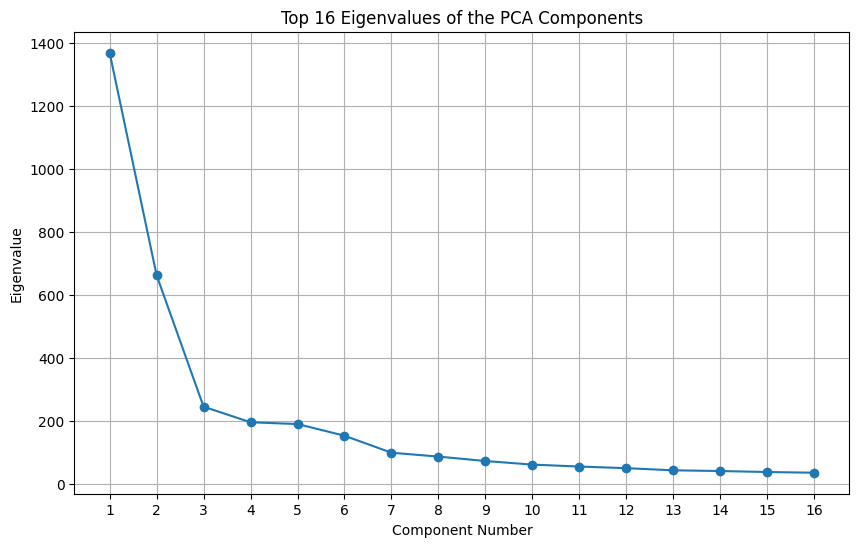

In [8]:
plt.figure(figsize=(10, 6))
# Plot the first 16 eigenvalues
plt.plot(pca.eigenvalues[:16], marker='o')
plt.title('Top 16 Eigenvalues of the PCA Components')
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue')
plt.xticks(range(16), labels=[str(i+1) for i in range(16)])  # Label x-ticks from 1 to 16
plt.grid(True)
plt.show()


Now, you will use your eigencats to form a low-dimensional approximation of the data. Each original (scaled) cat image can be approximated by a weighted sum of eigencats, where the weight associated with the $i^{th}$ eigencat corresponds to the projection of the original cat image onto the $i^{th}$ eigencat. Since the eigencats have norm = 1 (you can verify this!), the projection of an image onto each eigencat is simply the inner product between the image and the eigencat.

- Select an image of your choice from the original (scaled) dataset. 
   * Calculate the projection of this image onto the set of all principal components. This will result in a vector of length 4096, whose entries correspond to weights associated with each eigencat.
   * Reconstruct the image from the set of *all* principal components. Display the resulting image.
   * Reconstruct the image using only 1,2,8,16, and 32 principal components. Display all resulting images.
- Repeat the above steps using another randomly selected image.


In [9]:
# verify each eigencat have norm 1
for i in range(16):
    print(f'Norm of EigenCat {i+1}: {LA.norm(pca.eigenvectors[:,i])}')

Norm of EigenCat 1: 1.0000000000000002
Norm of EigenCat 2: 0.9999999999999994
Norm of EigenCat 3: 0.9999999999999996
Norm of EigenCat 4: 0.9999999999999994
Norm of EigenCat 5: 1.0000000000000002
Norm of EigenCat 6: 1.0000000000000016
Norm of EigenCat 7: 1.0
Norm of EigenCat 8: 1.0000000000000016
Norm of EigenCat 9: 1.0
Norm of EigenCat 10: 0.9999999999999991
Norm of EigenCat 11: 0.9999999999999998
Norm of EigenCat 12: 1.0000000000000002
Norm of EigenCat 13: 0.9999999999999987
Norm of EigenCat 14: 0.9999999999999996
Norm of EigenCat 15: 0.9999999999999997
Norm of EigenCat 16: 0.9999999999999998


Original Image


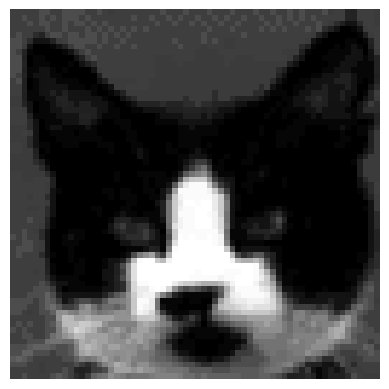

None
Resconstructed with all components


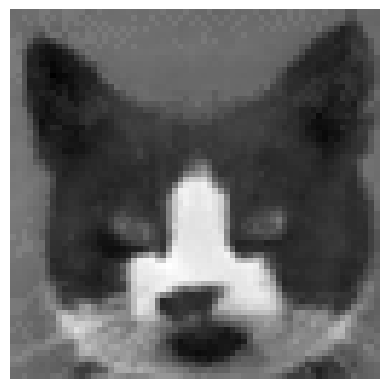

None


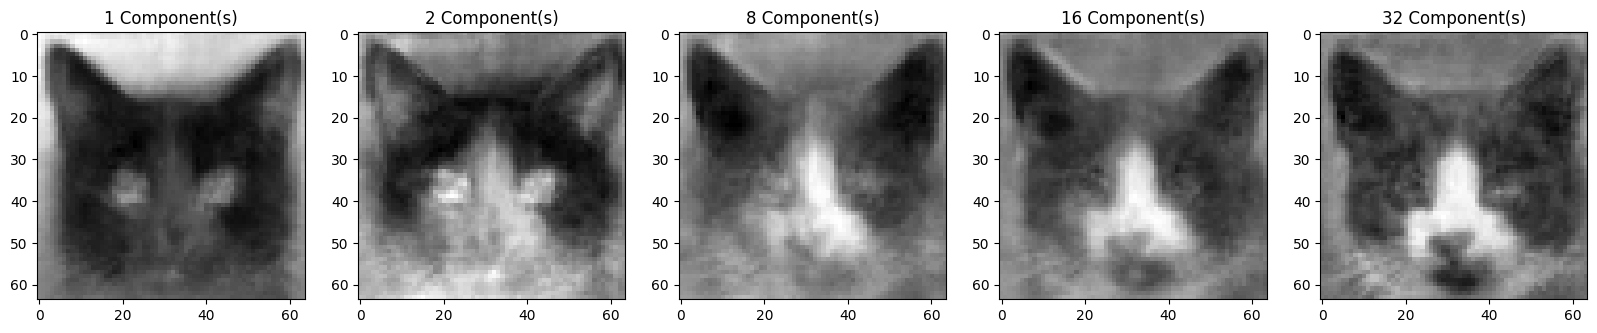

In [10]:
# Select an image and reconstruct it using different number of components
image_idx = 0
image = cat_matrix[image_idx]

#print a title for the image
print('Original Image')
print(vis_cat_image(image))

# calculate the projection of the image onto all principal components
projection = pca.project(len(cat_matrix))

 # reconstruct the image using all principal components
reconstruction = pca.reconstruct(len(cat_matrix))
print('Resconstructed with all components')
print(vis_cat_image(reconstruction[image_idx]))

# reconstruct the image using 1 principal component
components = [1,2,8,16,32];
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, num_components in enumerate(components):
    reconstruction = pca.reconstruct(num_components)
    ax = axes[i]
    vis_cat_image(reconstruction[image_idx], axis=ax)
    ax.set_title(f'{num_components} Component(s)')

**Question 1** Write down some of your observations about the appearance of the eigencats.

<font color='blue'>
The 16 eigencats have the most prominent features of all the cats images. The top eigencat (highest eigenvalue) captures general details like the overall shape of the face, the position of eyes and ears, etc. The eigencats with lower eigenvalues represent specific details or subtle variations, like the details of fur color.
</font>

**Question 2** What happens to the reconstructed image as you include more and more principal components?

<font color='blue'>
The eigencats become more sharp and focused as number of components (aka dimensions) for reconstruction increases. To be specific, more components allow the reconstruction to recognize the white spots around the cat's nose; also the mouth is getting more recognizable.
</font>

--- 
## Part 2: Clustering


In this part, we will perform clustering on the cat images using k-means. Since the images are quite high-dimensional (4096 dimensions), we will use PCA to project the data into a lower-dimensional space prior to clustering. 

**Question 3**  Based on your analysis in Part 1, how many principal components are needed to explain 90% of the variance in the data?

<font color='blue'>
29 components (see code below).

In [11]:
print(pca.get_number_of_components_by_variance_explained(0.9))

29


- Project each cat image onto the set of $L$ eigencats that capture 90% variance in the data. Now, each image is represented by $L$ coordinates (i.e., its projection onto $L$ eigencats) instead of 4096.
- Perform k-means clustering on the resulting vectors, using K=4. You may use functions from scikit-learn.
- This results in 4 cluster centroids. Project those cluster centroids back into the original (4096-dimensional) space, and display each of those 4 centroid cats using the function `viz_cat_image` above.

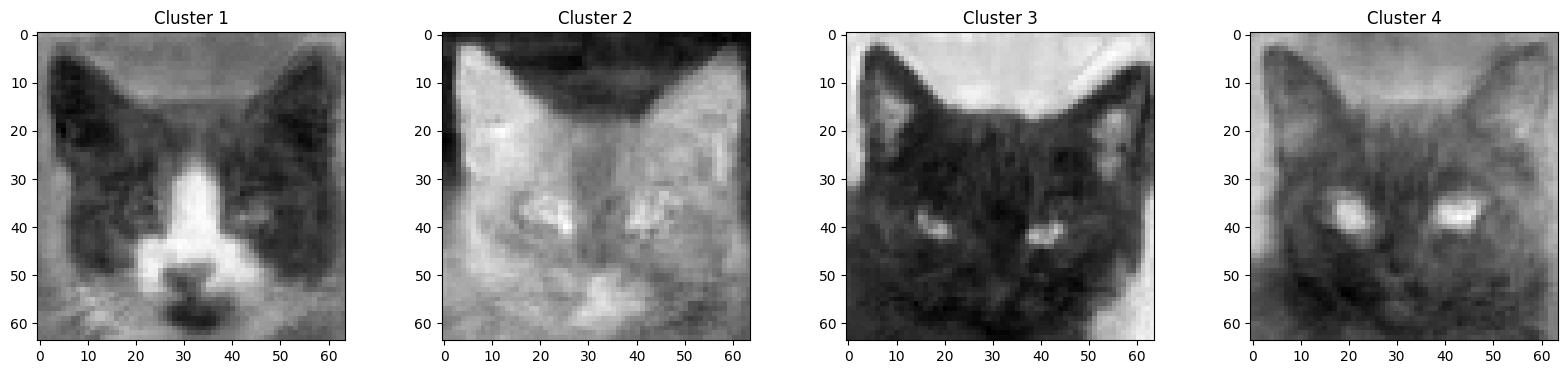

In [12]:
from sklearn.cluster import KMeans

# If you follow the PCA class above, you can use the following code
num_comp = pca.get_number_of_components_by_variance_explained(.9)
data_projected = pca.project(num_comp)

# Fit KMeans to the projected data
kmeans = KMeans(n_clusters=4, random_state=0).fit(data_projected)

# Project the centroids back to the original space
centroids = pca.reconstruct(num_comp)

# Visualize the centroids
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for i in range(4):
    ax = axes[i]
    vis_cat_image(centroids[i], axis=ax)
    ax.set_title(f'Cluster {i+1}')

--- 
## Part 3: Deep Learning for Sentiment Analysis

 

In this part, you will be using Keras/PyTorch to build a fully-connected, feed-forward neural network for sentiment analysis. The [dataset](https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification) you will be working with contains 50,000 movie reviews from IMDB and the corresponding labels, where the label indicates whether the review was positive or negative. 

If you are using Keras, make sure you install the tensorflow at first since keras is just a wrapper API package for tensorflow

In [13]:
from keras.datasets import imdb
import torch

# todo: add more keras/pytorch imports as needed 

- To begin, run the code block below to load the training and test sets of IMDB data from Keras/PyTorch. Each review (sample) is represented as a sequence of integers, one integer for each word in that review, where the integer assigned to a given word corresponds to the index of that word in the vocabulary. Note that below, we will turn these samples into fixed-length binary vectors. 

In [14]:
# fetch dataset from keras (already has a 50/50 train/test split)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000, seed=113)

# concatenate the data (N = 50,000)
X = np.concatenate((np.array(x_train, dtype=object), np.array(x_test, dtype=object)), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
y = y[..., np.newaxis]  # (N, ) -> (N,1)

# transform X such that every input is the same length 
## 1 if input x contains the word, 0 otherwise
## so, we are ignoring word frequency 
X_vec = np.zeros((50000,10000))
for i, x in enumerate(X):
    X_vec[i, x] = 1

# 80/20 train/test split
x_train = X_vec[:40000]
y_train = y[:40000]
x_test = X_vec[40000:]
y_test = y[40000:]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((40000, 10000), (40000, 1), (10000, 10000), (10000, 1))

- Using the Keras/PyTorch framework, build a fully-connected, feed-forward neural network for the IMDB dataset. This network should take in the binary vector representations of movie reviews and predict the positive/negative sentiment of the reviews. 
    * Take advantage of Keras’ online documentation. Additional supplemental materials by the TA may be referenced, but should not be used as a template for your homework.
- Hint: use binary cross-entropy as your loss function. 
- **Submit a neural network that reaches >= 85% accuracy on the test set.**

In [15]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(10000, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)
    
    def predict(self, x, threshold=0.5):
        return self.forward(x) >= threshold
    
    def fit(self, x, y, epochs=100, lr=0.01):
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
        for epoch in range(epochs):
            self.train()
            optimizer.zero_grad()
            outputs = self.forward(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            
            if epoch % 10 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

In [16]:
# Your TA uses two hidden layers with less than 100 units in each layer
# You can use any optimizer you want
# 100-epoch training takes less than 3 minutes on a CPU
# learning rate = 0.01 can achieve 87% accuracy on the test set

model = MLP()

# train the model
model.fit(torch.Tensor(x_train), torch.Tensor(y_train), epochs=100, lr=0.01)


Epoch 1/100, Loss: 0.6947349905967712
Epoch 11/100, Loss: 0.2879396677017212
Epoch 21/100, Loss: 0.15289053320884705
Epoch 31/100, Loss: 0.10557932406663895
Epoch 41/100, Loss: 0.05351393297314644
Epoch 51/100, Loss: 0.01403868105262518
Epoch 61/100, Loss: 0.0035516952630132437
Epoch 71/100, Loss: 0.0010512347798794508
Epoch 81/100, Loss: 0.0004961534286849201
Epoch 91/100, Loss: 0.00029889060533605516


In [17]:
model.eval()

with torch.no_grad():
    # Make predictions
    predictions = model(torch.Tensor(x_test))
    # Apply a threshold of 0.5 to determine binary classification
    predicted_labels = predictions >= 0.5
    # Flatten y_test to ensure it matches the dimensionality of predicted_labels for accurate comparison
    correct_predictions = (predicted_labels.flatten().int() == torch.Tensor(y_test).flatten().int()).sum().item()
    # Calculate accuracy
    accuracy = correct_predictions / len(y_test.flatten())

print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.8734


**Question 4** Specify the optimization method and activation function(s) that you used.

<font color='blue'>
I used Adam Optimizer for updating the network's weights during training. It is effective in handling sparse gradients, so it works perfectly on this dataset.

I used both ReLU for the hidden layers, and Sigmoid for the output layer as activation functions. ReLU is majorly used because it is simple and non-linear, allowing a more complex fit while making computations efficient. Sigmoid is simply very useful for binary classification tasks like this.

</font>


**Question 5** Provide a brief reflection on the process by which you tweaked your network to improve its performance.

<font color='blue'>
First, I was not sure what should I set my number of layers to be. I ended up using 4 layers to get a more exhaustive training model. Also, the layer sizes. I initially had `fc1` equals from 10000 to 256 neurons, but it is not as good as 128 neurons. Finally, the learning rate. I did not tweak it, I just used what TA suggests - 0.01 works out perfectly, and brings the accuracy to almost 88%.


---
## Part 4: Submission 

Please upload a clean version of your work to Brightspace by the deadline. Below, please acknowledge your collaborators as well as any resources/references (beyond Keras and guides to Python syntax) that you have used in this assignment:

<font color='blue'>
As always, ChatGPT has been very useful. Also, I have learned to use Github Copilot. Besides that, the dataset documentation on part 3 is helpful as well.